# Proyecto 5: Análisis de sentimiento en reviews de películas

En este proyecto vamos a trabajar con un dataset de reviews de películas. El objectivo es clasificar cada comentario de acuerdo al sentimiento positivo o negativo hacia la película. Para hacerlo, vamos a trabajar con procesamiento de texto para luego aplicar las diferentes técnicas predictivas que hemos visto.

## Dataset

En primer lugar, carguemos las reviews para comenzar a procesarlas. En este caso no tenemos un archivo `.csv`, sino un directorio estructurado de la siguiente forma: 
```
movie_reviews/
  neg/
  pos/
```
`sklearn` nos provee de la función `load_files` que permite recorrer este tipo de estructuras. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.datasets import load_files
moviedir = r'/content/drive/My Drive/Colab Notebooks/entrega+5/dataset/movie_reviews' 
movie_reviews = load_files(moviedir, shuffle=True)

Ahora en la variable `movies` tendremos guardadas las reviews (`movies.data`) y su sentimiento (`movies.target`).
Veamos cuantas reviews tenemos en total:

In [3]:
print("Tenemos {} reviews, con clases {},".format(len(movie_reviews.data), movie_reviews.target_names))

Tenemos 2000 reviews, con clases ['neg', 'pos'],


Analizando la estructura de los documentos, veamos como luce una muestra de `movies.data`:

In [4]:
movie_reviews.data[0][:500]

b"arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . \nit's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? \nonce again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . \nin this so cal"

Y ahora, con la propiedad `target` podemos ver la categoría asociada a esta review

In [5]:
movie_reviews.target[0]

0

En este caso es un 0, es decir `neg`.

## Separando en conjuntos de entrenamiento y de testeo

Antes de comenzar con el entrenamiento de los modelos probando distintos algoritmos para encontrar los mejores modelos, vamos a separar el conjunto de reviews en training y testing. 

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    movie_reviews.data, movie_reviews.target, test_size = 0.20, stratify=movie_reviews.target, random_state = 12)

## Preprocesamiento

Para trabajar con texto tenemos que realizar una serie de pasos antes de poder entrenar un modelo. Es decir, buscar la forma de convertir el texto a una representación numérica que pueda ser interpretable por los algoritmos de clasificación. 
Para ello vamos a realizar una serie de pasos.
- Tokenizar el texto
- Convertir a vectores de términos/documentos
- Aplicar tfidf


Es importante destacar que el `fit` debe hacerse sobre el conjunto de `train` y no sobre el total, ya que `tfidf` tiene en cuenta la frecuencia de aparición de las palabras respecto al total del conjunto. Una vez que usamos el `fit` con el conjunto de entrenamiento podemos aplicar la transformación al conjunto de `test`. 

**1) Vectorizá** los textos para obtener una matriz de términos/documentos utilizando td-idf. 

In [0]:
# Realizá los pasos necesarios para vectorizar los conjuntos de entrenamiento y testeo en este celda
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(strip_accents='unicode', stop_words='english', token_pattern='\w+')
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [8]:
tfidf_vect.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': 'unicode',
 'sublinear_tf': False,
 'token_pattern': '\\w+',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

### Dimensión de la matriz de términos
Una vez vectorizados los documentos veamos qué forma tiene la matriz resultante

In [9]:
X_train_tfidf.shape

(1600, 36073)

__¿ Por qué tiene estas dimensiones ?__

Responder.

Porque el resultado es una matriz de términos por documentos. Por cada término existente en el dataset habrá una columna, ya que no se realizó ningún tipo de filtrado.

## Entrenando los modelos
Una vez que tenemos una matriz con los vectores correspondientes a los documentos luego de aplicarse td-idf podemos comenzar con el proceso de entrenamiento de los modelos. Para eso, vamos a comparar diferentes algoritmos vistos como SVM, Random Forest, AdaBoost, Voting. Y todos los algoritmos complementarios que se quieran introducir. 
Para el entrenamiento de los modelos usaremos GridSearch recorriendo una lista de parámetros según corresponda a cada algoritmo. Además usaremos 5-fold CV y el scoring estará dado por el área bajo la curva roc.

### Support Vector Machines (SVM)

__Ajustar un SVM (kernel lineal) al conjunto de datos de entrenamiento y devolver la matriz de confusión en testing.__

Basándonos en el paper https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf, vamos a utilizar un kernel lineal. Al tener menos instancias que features este es el procedimiento recomendado. 

Nuestro espacio de parámetros para recorrer de forma exhaustiva utilizando GridSearch será el siguiente:

* C = [0.001, 0.01, 0.1, 1, 10]
* loss = ['hinge', 'squared_hinge'] 

**2) Entrenar** un modelo utilizando `Grid Search` y el clasificador `LinearSVC` con `5-fold` cross validation y que utilice como `scoring` el área bajo la curva roc.

In [10]:
# Realizá el entrenamiento en esta celda
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

lsvm = LinearSVC()

param_grid_svm = {'loss':['hinge', 'squared_hinge'],
              'C':[0.001, 0.01, 0.1, 1, 10]}

grid_search_svm = GridSearchCV(lsvm, param_grid=param_grid_svm, scoring='roc_auc' , cv=5)
grid_search_svm.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'loss': ['hinge', 'squared_hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

Veamos los resultados promediados por cada combinación de parámetros:

In [0]:
svm_results = list(zip(grid_search_svm.cv_results_['mean_test_score'], grid_search_svm.cv_results_['params']))

In [13]:
sorted(svm_results, key=lambda x: -x[0])

[(0.9153281249999999, {'C': 10, 'loss': 'squared_hinge'}),
 (0.9147578125000001, {'C': 10, 'loss': 'hinge'}),
 (0.9146171875, {'C': 1, 'loss': 'squared_hinge'}),
 (0.9132578125, {'C': 1, 'loss': 'hinge'}),
 (0.8931250000000001, {'C': 0.1, 'loss': 'squared_hinge'}),
 (0.8708281249999998, {'C': 0.01, 'loss': 'squared_hinge'}),
 (0.8669453125000001, {'C': 0.001, 'loss': 'squared_hinge'}),
 (0.8660468750000001, {'C': 0.001, 'loss': 'hinge'}),
 (0.8660468750000001, {'C': 0.01, 'loss': 'hinge'}),
 (0.8660468750000001, {'C': 0.1, 'loss': 'hinge'})]

In [14]:
grid_search_svm.best_params_

{'C': 10, 'loss': 'squared_hinge'}

In [0]:
optimised_svm = grid_search_svm.best_estimator_

## Matriz de confusión 
Una forma de ver fácilmente el resultado de un clasificador es utilizando una matriz de confusión. A continuación
se presenta una función para visualizar una matriz de confusión utilizando `matplotlib`.

In [0]:
import numpy as np
import itertools
import matplotlib.pylab as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



**3) Mostrá** los resultados de la predicción del clasificador `LinearSVC` sobre el conjunto de test con una matriz de confusión

Confusion matrix, without normalization
[[159  41]
 [ 28 172]]


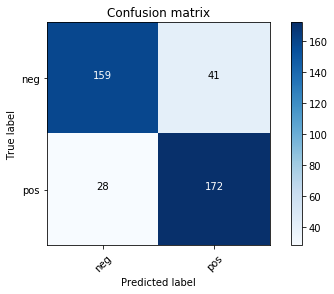

In [17]:
# Mostrá la matriz de confusión en esta celda
from sklearn.metrics import confusion_matrix

y_test_pred_svm = optimised_svm.predict(X_test_tfidf)
y_scores_svm = optimised_svm.decision_function(X_test_tfidf)

cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plot_confusion_matrix(cm_svm, classes=movie_reviews.target_names)

**4) Calcular** el área bajo la curva ROC (AUC) en el conjunto de testing para el modelo y mostrá el `classification_report`

In [18]:
# Mostrá el roc_auc score y el classification_report en esta celda
from sklearn.metrics import roc_auc_score

mov_roc_svm = roc_auc_score(y_test, y_scores_svm)
print(mov_roc_svm)

0.921825


In [19]:
from sklearn.metrics import classification_report

report_svm = classification_report(y_test, y_test_pred_svm)
print(report_svm)

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       200
           1       0.81      0.86      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



### Random Forests
El siguiente modelo que vamos a entrenar es utilizando la técnica de Random Forest. 

__5) Usando grid search__ con cross validation (5 folds), encontrar el mejor modelo según el AUC dado el siguiente espacio de búsqueda:

* n_estimators = [100, 500, 1000]
* max_depth: [3, 7, None]
* min_samples_split: [2, 3, 10]
* bootstrap: [True, False]
* criterion: ["gini", "entropy"]

(puede tardar un poco la ejecución dado el tamaño del dataset)

In [20]:
# entrenar el modelo en esta celda
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid_rf = {'n_estimators':[100, 500, 1000],
                 'max_depth':[3, 7, None],
                 'min_samples_split': [2, 3, 10],
                 'bootstrap': [True, False],
                 'criterion': ["gini", "entropy"]
                }

grid_search_rf = GridSearchCV(rf, param_grid=param_grid_rf, scoring='roc_auc' , cv=5)
grid_search_rf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

**6) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `Random Forest`. Es decir, mostrar la matriz de confusión, scores, etc

In [0]:
rf_results = list(zip(grid_search_rf.cv_results_['mean_test_score'], grid_search_rf.cv_results_['params']))

In [22]:
sorted(rf_results, key=lambda x: -x[0])

[(0.898125,
  {'bootstrap': False,
   'criterion': 'entropy',
   'max_depth': None,
   'min_samples_split': 10,
   'n_estimators': 1000}),
 (0.8980195312499999,
  {'bootstrap': False,
   'criterion': 'entropy',
   'max_depth': None,
   'min_samples_split': 3,
   'n_estimators': 500}),
 (0.8976796874999999,
  {'bootstrap': False,
   'criterion': 'entropy',
   'max_depth': None,
   'min_samples_split': 3,
   'n_estimators': 1000}),
 (0.8972695312500001,
  {'bootstrap': False,
   'criterion': 'entropy',
   'max_depth': None,
   'min_samples_split': 2,
   'n_estimators': 1000}),
 (0.8953359375,
  {'bootstrap': False,
   'criterion': 'entropy',
   'max_depth': None,
   'min_samples_split': 10,
   'n_estimators': 500}),
 (0.8934843750000001,
  {'bootstrap': True,
   'criterion': 'entropy',
   'max_depth': None,
   'min_samples_split': 3,
   'n_estimators': 1000}),
 (0.8933789062499999,
  {'bootstrap': False,
   'criterion': 'entropy',
   'max_depth': None,
   'min_samples_split': 2,
   'n_es

In [0]:
optimised_rf = grid_search_rf.best_estimator_

Confusion matrix, without normalization
[[170  30]
 [ 40 160]]


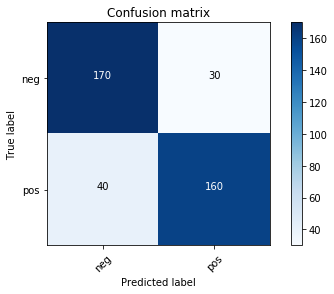

In [25]:
y_test_pred_rf = optimised_rf.predict(X_test_tfidf)
y_scores_rf = optimised_rf.predict_proba(X_test_tfidf)

cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plot_confusion_matrix(cm_rf, classes=movie_reviews.target_names)

In [26]:
mov_roc_rf = roc_auc_score(y_test, y_scores_rf[:,1])
print(mov_roc_rf)

0.9202


In [27]:
report_rf = classification_report(y_test, y_test_pred_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       200
           1       0.84      0.80      0.82       200

    accuracy                           0.82       400
   macro avg       0.83      0.82      0.82       400
weighted avg       0.83      0.82      0.82       400



### Multilayer Perceptron

**6) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `Multilayer Perceptron`. Es decir, mostrar la matriz de confusión, scores, etc

El `param_grid` debe recorrer estos valores: `{'hidden_layer_sizes': [(10,),(5,5), (2,2)]}`

In [28]:
from sklearn.neural_network import MLPClassifier

mpclf = MLPClassifier()

param_grid_mp = {'hidden_layer_sizes': [(10,),(5,5), (2,2)]}

grid_search_mp = GridSearchCV(mpclf, param_grid=param_grid_mp, scoring='roc_auc' , cv=5)
grid_search_mp.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=

In [0]:
mp_results = list(zip(grid_search_mp.cv_results_['mean_test_score'], grid_search_mp.cv_results_['params']))

In [30]:
sorted(mp_results, key=lambda x: -x[0])

[(0.9063437499999999, {'hidden_layer_sizes': (10,)}),
 (0.9022656249999998, {'hidden_layer_sizes': (5, 5)}),
 (0.736984375, {'hidden_layer_sizes': (2, 2)})]

In [0]:
optimised_mp = grid_search_mp.best_estimator_

Confusion matrix, without normalization
[[155  45]
 [ 24 176]]


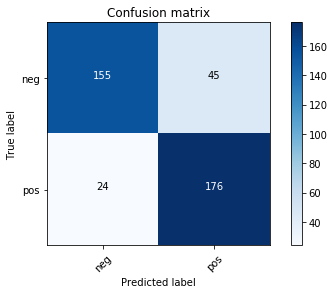

In [32]:
y_test_pred_mp = optimised_mp.predict(X_test_tfidf)
y_scores_mp = optimised_mp.predict_proba(X_test_tfidf)

cm_mp = confusion_matrix(y_test, y_test_pred_mp)
plot_confusion_matrix(cm_mp, classes=movie_reviews.target_names)

In [33]:
mov_roc_mp = roc_auc_score(y_test, y_scores_mp[:,1])
print(mov_roc_mp)

0.911475


In [35]:
report_mp = classification_report(y_test, y_test_pred_mp)
print(report_mp)

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       200
           1       0.80      0.88      0.84       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



### AdaBoost

**7) Repetir** los mismos pasos utilizados con el anterior modelo pero esta vez para `AdaBoost`. Es decir, mostrar la matriz de confusión, scores, etc

El `param_grid` debe recorrer estos valores: `{'n_estimators': [50, 100, 500]}`


In [36]:
from sklearn.ensemble import AdaBoostClassifier

abclf = AdaBoostClassifier()

param_grid_ab = {'n_estimators': [50, 100, 500]}

grid_search_ab = GridSearchCV(abclf, param_grid=param_grid_ab, scoring='roc_auc' , cv=5)
grid_search_ab.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'n_estimators': [50, 100, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [0]:
ab_results = list(zip(grid_search_ab.cv_results_['mean_test_score'], grid_search_ab.cv_results_['params']))

In [38]:
sorted(ab_results, key=lambda x: -x[0])

[(0.8548203124999999, {'n_estimators': 500}),
 (0.8379843750000001, {'n_estimators': 100}),
 (0.8143671875, {'n_estimators': 50})]

In [0]:
optimised_ab = grid_search_ab.best_estimator_

Confusion matrix, without normalization
[[151  49]
 [ 33 167]]


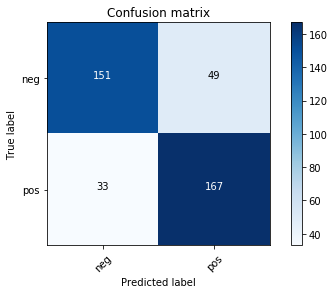

In [40]:
y_test_pred_ab = optimised_ab.predict(X_test_tfidf)
y_scores_ab = optimised_ab.predict_proba(X_test_tfidf)

cm_ab = confusion_matrix(y_test, y_test_pred_ab)
plot_confusion_matrix(cm_ab, classes=movie_reviews.target_names)

In [41]:
mov_roc_ab = roc_auc_score(y_test, y_scores_ab[:,1])
print(mov_roc_ab)

0.8820249999999998


In [42]:
report_ab = classification_report(y_test, y_test_pred_ab)
print(report_ab)

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       200
           1       0.77      0.83      0.80       200

    accuracy                           0.80       400
   macro avg       0.80      0.79      0.79       400
weighted avg       0.80      0.80      0.79       400



__8) Armar un ensamble entre los cuatro modelos usando votación y medir el accuracy de cada uno de los modelos.__


In [43]:
  from sklearn.ensemble import VotingClassifier

  eclf = VotingClassifier(estimators=[('svm', optimised_svm), ('rf', optimised_rf), ('mp', optimised_mp), ('ab', optimised_ab)], voting='hard')
  eclf.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('svm',
                              LinearSVC(C=10, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features=...
                                            momentum=0.9, n_iter_no_chang

In [0]:
from sklearn.model_selection import cross_val_score
for clf, label in zip([optimised_svm, optimised_rf, optimised_mp, optimised_ab, eclf], ['Linear SVM', 'Random Forest', 'Multilayer Perceptron', 'AdaBoost', 'Ensemble']):
    scores = cross_val_score(clf, X_test_tfidf, y_test, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.77 (+/- 0.05) [Linear SVM]
Accuracy: 0.77 (+/- 0.06) [Random Forest]
Accuracy: 0.72 (+/- 0.07) [Multilayer Perceptron]
Accuracy: 0.72 (+/- 0.07) [AdaBoost]
Accuracy: 0.76 (+/- 0.06) [Ensemble]


In [44]:
confidence = eclf.score(X_test_tfidf, y_test)
print('accuracy:', confidence)

accuracy: 0.86


In [0]:
y_pred = eclf.predict(X_test_tfidf)

__9) Seleccioná el modelo__ que te haya dado el mejor score y utilizalo como tu modelo final. Reentrenalo con todos tus datos de entrenamiento.


In [46]:
# Guardamos el modelo
from sklearn.externals import joblib
joblib.dump(eclf, '/content/drive/My Drive/Colab Notebooks/entrega+5/sentiment.pkl') 

['/content/drive/My Drive/Colab Notebooks/entrega+5/sentiment.pkl']

In [47]:
y_pred

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,

## Clasificación de reviews de Rocky 4.

A partir de [criticas de la película Rocky 4](https://www.rottentomatoes.com/m/rocky_iv/reviews/?type=user) veamos como las clasifica nuestro mejor modelo

In [0]:
reviews_new = ["Stallone creates credible villains worthy of his heroic character.",
               "Another brilliant Rocky film, probably my favourite one out of the lot",
               "Yeah, this movie sucks.",
               "My favourite rocky film! So good so much heart. Slightly better than 2",
               "What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!",
               "The new film's narrative is stripped down to essentials, which gives it an emblematic quality.",
               "Absurdly ridiculous, this just isn't a good movie at all", 
               "Very basic and predictable but still an okay movie. No special music to save this one.", 
              "Rocky 4 is an extremely ambitious movie that is definitely worth watching.",
              'Highly beautiful',
               "If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would otherwise be nothing more than an interminable series of mildly rousing montages. There are some unintentionally funny bits though, and Dolph's Ivan showcases the best and worst of all Rocky's opponents.",
              "While all aspects of realism is thrown out the window, ROCKY IV is an adrenaline rush of action and excitment, with an incredible soundtrack and arguably the best movie fight in history between Balboa and Drago",
              "Just like the songs, exercise routines and repetitive clips, it seems redundant to add another installment in this already falling franchise when you clearly lack material. Rocky IV is petty, childish and seems overlong despite of its 91 minutes of run time for it merely has an idea of a TV drama episode which is stretched to a point of exhaustion. Its painful to watch Sylvester Stallone go through this enormous amount of training and hardly make a point out there. He fails on all the levels here; writer, director and actor, to deliver any loose end of the thread for the audience to hang on to. Rocky IV is predictable, loosely written and choreographed and executed unsupervised."]
reviews_new_counts = tfidf_vect.transform(reviews_new)
reviews_new_tfidf = tfidf_vect.transform(reviews_new)

In [0]:
pred = eclf.predict(reviews_new_tfidf)

In [50]:
for review, category in zip(reviews_new, pred):
    print('%r => %s \n' % (review, movie_reviews.target_names[category]))

'Stallone creates credible villains worthy of his heroic character.' => pos 

'Another brilliant Rocky film, probably my favourite one out of the lot' => pos 

'Yeah, this movie sucks.' => neg 

'My favourite rocky film! So good so much heart. Slightly better than 2' => pos 

'What has this got to do with boxing. Also everyone looked like dolls. Also if you are a real true boxing fan (not casuals), you would understand that this stupidity is no description of boxing!!' => neg 

"The new film's narrative is stripped down to essentials, which gives it an emblematic quality." => pos 

"Absurdly ridiculous, this just isn't a good movie at all" => neg 

'Very basic and predictable but still an okay movie. No special music to save this one.' => neg 

'Rocky 4 is an extremely ambitious movie that is definitely worth watching.' => pos 

'Highly beautiful' => pos 

"If it wasn't for the robots (WTF????), and the painfully overwritten lines of an absurdly dogmatic persuasion, then this would oth